## Quality control

Data quality control can be split into cell QC and gene QC. Typical quality measures for assessing the quality of a cell include the number of molecule counts (UMIs), the number of expressed genes, and the fraction of counts that are mitochondrial. A high fraction of mitochondrial reads being picked up can indicate cell stress, as there is a low proportion of nuclear mRNA in the cell. It should be noted that high mitochondrial RNA fractions can also be biological signals indicating elevated respiration.

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import GProfiler
import rpy2.rinterface_lib.callbacks
import logging
from rpy2.robjects import pandas2ri
import anndata2ri
import doubletdetection as dd
from gseapy.plot import barplot, dotplot
import os, sys
import gseapy as gp
from anndata import AnnData

import scipy.stats
import diffxpy.api as de
import anndata
from batchglm.api.models.tf1.glm_nb import Simulator

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()


plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 0   # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=200, dpi_save=300, facecolor='white')
sc.logging.print_versions()
sc.logging.print_header()

# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)
%load_ext rpy2.ipython

%matplotlib inline

plt.rcParams.update({'font.size': 22})

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

-----
anndata     0.7.5
scanpy      1.6.1
sinfo       0.3.1
-----
Crypto                                      3.10.1
OpenSSL                                     20.0.1
PIL                                         8.1.0
aa8f2297d25b4dc6fd3d98411eb3ba53823c4f42    NA
absl                                        NA
anndata                                     0.7.5
anndata2ri                                  1.0.6
appdirs                                     1.4.4
asciitree                                   NA
astunparse                                  1.6.3
backcall                                    0.2.0
backports                                   NA
batchglm                                    v0.7.4
bcrypt                                      3.2.0
beta_ufunc                                  NA
binom_ufunc                                 NA
bioservices                                 1.7.11
boto3                                       1.17.107
botocore                                    1

In [2]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
#.libPaths("/home/dan/R/x86_64-pc-linux-gnu-library/4.03")
#Sys.setenv(R_INSTALL_STAGED = FALSE)

#sudo apt-get install aptitude

#sudo apt-get install libcurl4-openssl-dev

#sudo apt-get install libxml2-dev

# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
#library(slingshot)
#library(monocle)
library(gam)
library(clusterExperiment)
library(ggplot2)
library(plyr)
library(MAST)
#library(scCB2)
#library(DropletUtils)
library(Seurat)
library(NMF)
library(BiocFileCache)

In [3]:
import pickle

# Getting back the objects:
with open('adata.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    adata = pickle.load(f)

In [4]:
# Quality control - calculate QC covariates
# sum the columns (genes) of a cell as 'n_counts', 
# transform the 'n_counts' to logarithm as 'log_counts'
# count how many expressed genes per cell as 'n_genes'
# 'mt_gene_mask' contains the Boolean values 'TRUE' or 'FALSE' if the gene name contains 'mt-' or not.
# 'mt_frac' contains mitochondrial gene fractions
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)
mt_gene_mask = [gene.startswith('mt-') for gene in adata.var_names]
adata.obs['mt_frac'] = adata.X[:, mt_gene_mask].sum(1)/adata.obs['n_counts']

/home/dan/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'sample' as categorical
/home/dan/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'age' as categorical
/home/dan/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will a

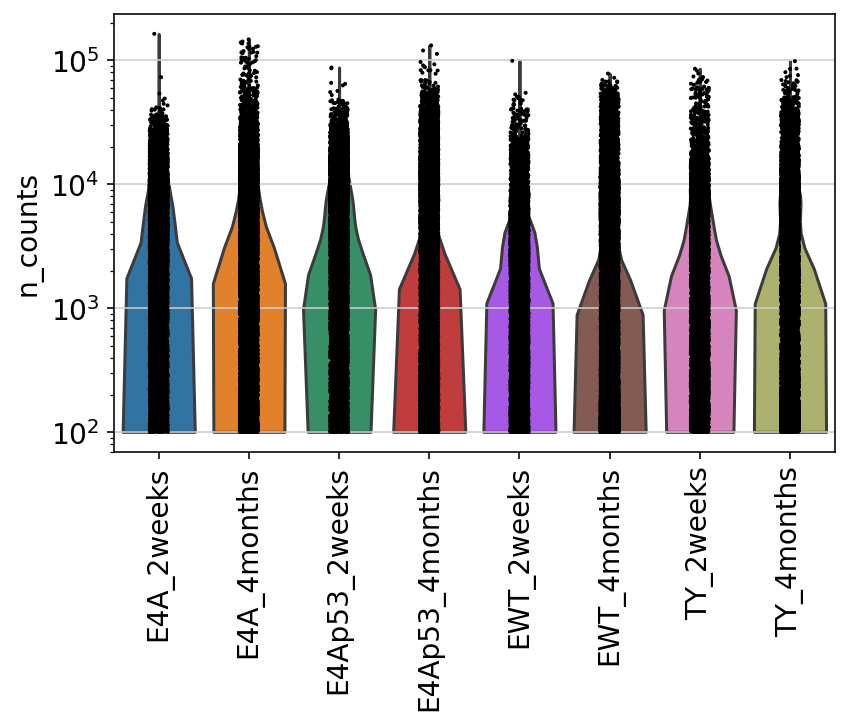

In [5]:
# Quality control - plot QC metrics
#Sample quality plots
t1 = sc.pl.violin(adata, keys = 'n_counts', groupby='genotype_age', size=2, log=True, cut=0, rotation = 90, save='n_counts.png')
t2 = sc.pl.violin(adata, keys = 'mt_frac', groupby='genotype_age', rotation = 90, save='mt_frac.png')

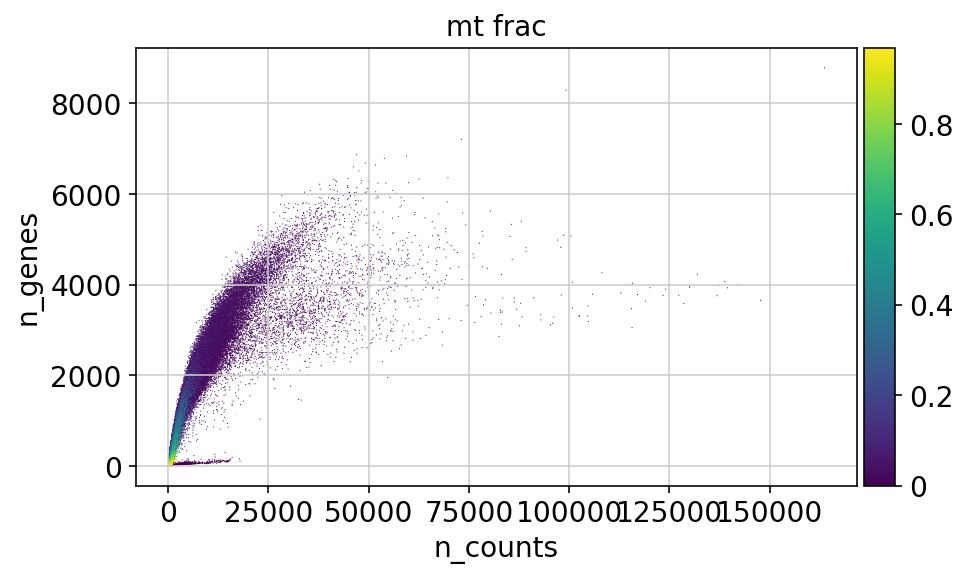

In [6]:
#Data quality summary plots
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', color='mt_frac', save='n_counts&n_genes_1.png')

In [7]:
import statistics
print("median counts:")
print(statistics.median(adata.obs['n_counts']))
print("median genes:")
print(statistics.median(adata.obs['n_genes']))

median counts:
2199.0
median genes:
918


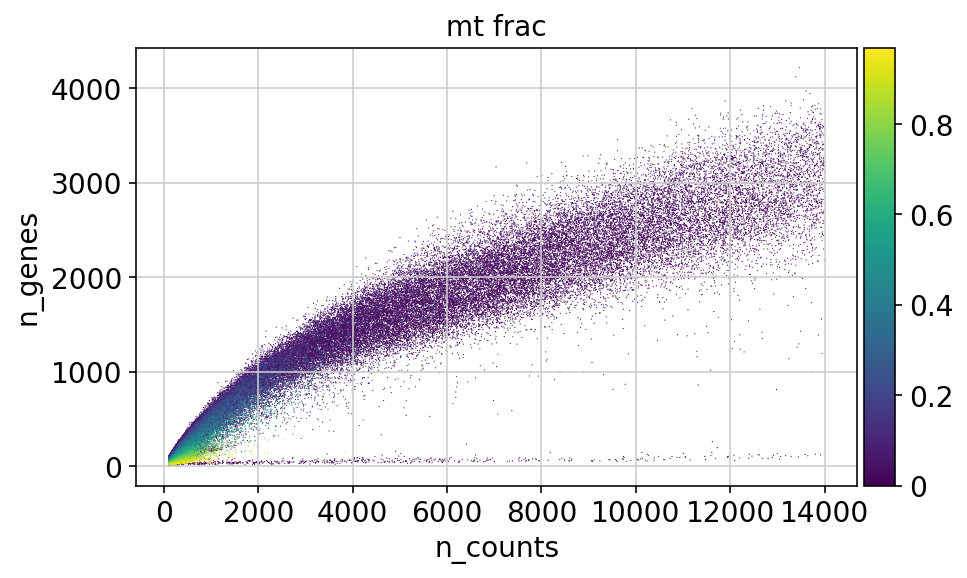

In [8]:
p2 = sc.pl.scatter(adata[adata.obs['n_counts']<14000], 'n_counts', 'n_genes', color='mt_frac', 
                   save='n_counts&n_genes_2.png')

By looking at plots of the number of genes versus the number of counts with MT fraction information, we can assess whether there cells with unexpected summary statistics. It is important here to look at these statistics jointly. For example, there is a cloud of points with many counts, but few genes. Our first instinct would be to filter out these as "dying" outliers, however they don't seem to show high MT fraction. We should probably still filter out some cells with very few genes as these may be difficult to annotate later. 

Furthermore it can be seen in the main cloud of data points, that cells with lower counts and genes tend to have a higher fraction of mitochondrial counts. These cells are likely under stress or are dying. When apoptotic cells are sequenced, there is less mRNA to be captured in the nucleus, and therefore fewer counts overall, and thus a higher fraction of counts fall upon mitochondrial RNA. If cells with high mitochondrial activity were found at higher counts/genes per cell, this would indicate biologically relevant mitochondrial activity.

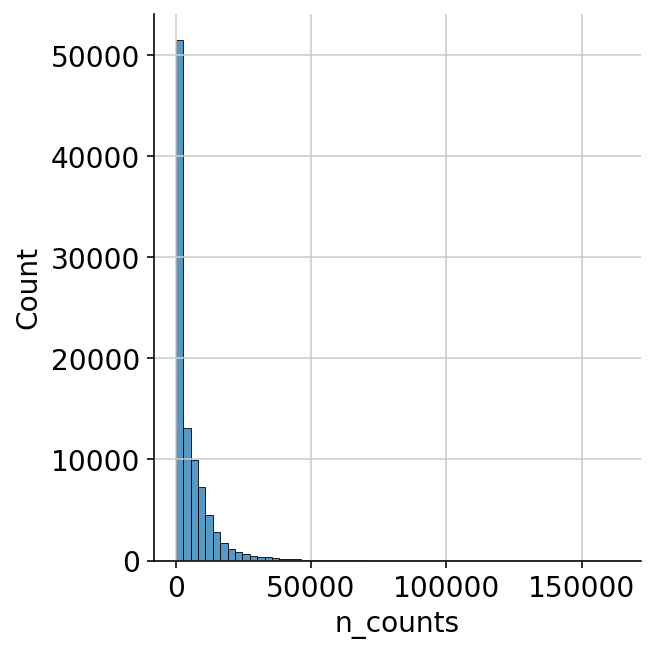

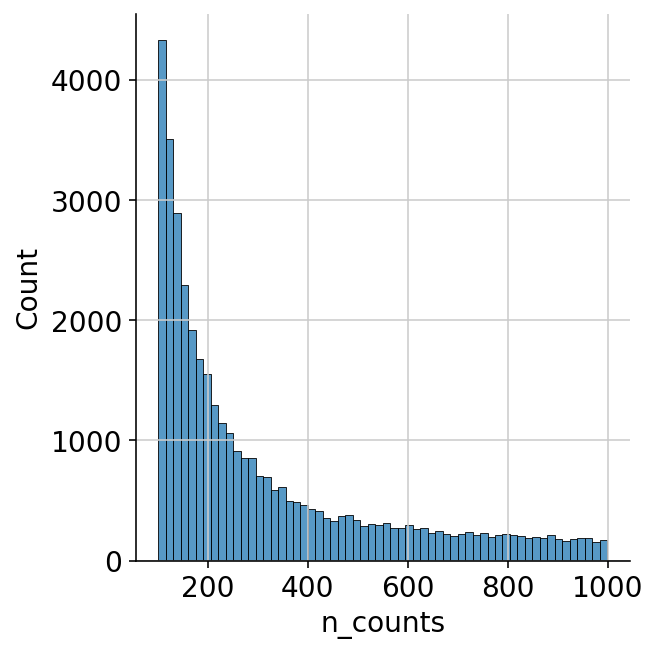

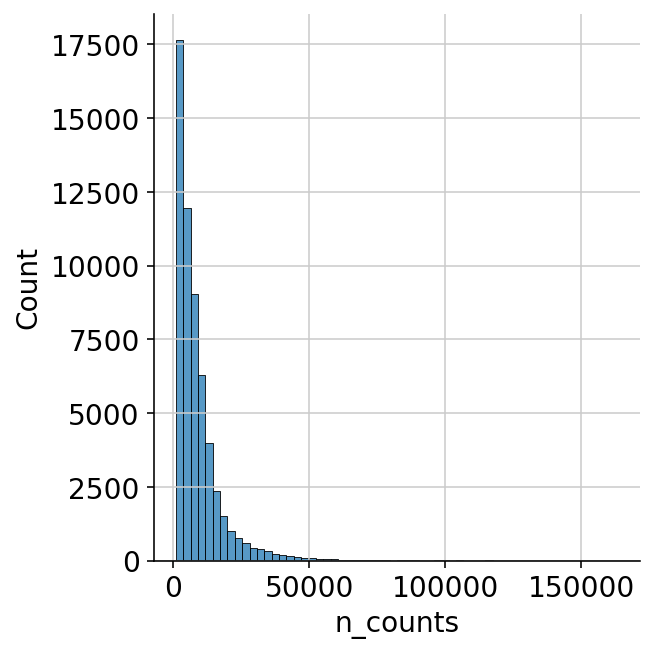

In [9]:
#Thresholding decision: counts
p3 = sb.displot(adata.obs['n_counts'], bins=60, kde=False)
plt.savefig('./figures/n_counts_hist.png', dpi=400)
plt.show()

p4 = sb.displot(adata.obs['n_counts'][adata.obs['n_counts']<1000], bins=60)
plt.savefig('./figures/n_counts_hist1.png', dpi=400)
plt.show()

p5 = sb.displot(adata.obs['n_counts'][adata.obs['n_counts']>1000], bins=60)
plt.savefig('./figures/n_counts_hist2.png', dpi=400)
plt.show()

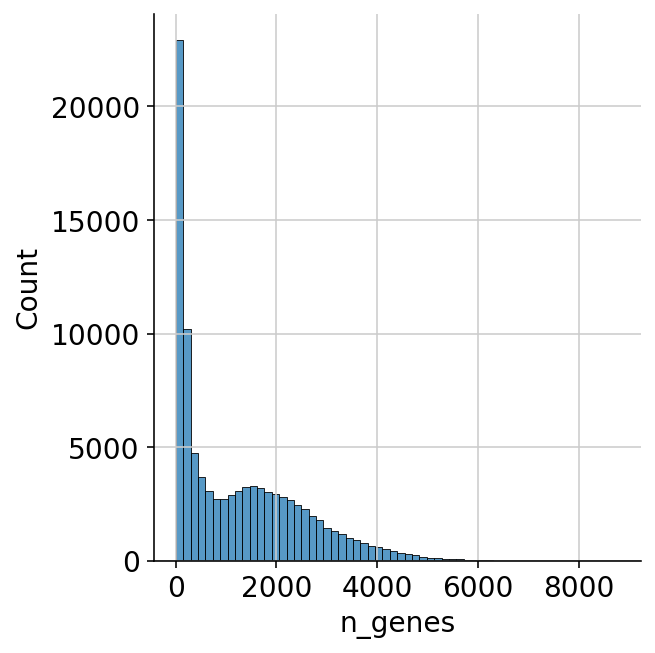

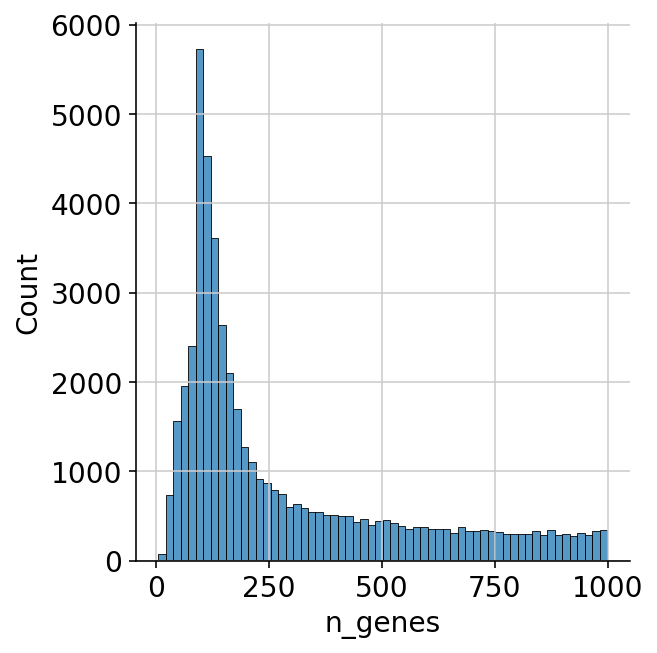

In [10]:
#Thresholding decision: genes
p6 = sb.displot(adata.obs['n_genes'], kde=False, bins=60)
plt.savefig('./figures/n_counts_hist7.png', dpi=400)
plt.show()

p7 = sb.displot(adata.obs['n_genes'][adata.obs['n_genes']<1000], kde=False, bins=60)
plt.savefig('./figures/n_counts_hist8.png', dpi=400)
plt.show()

Cells with low gene counts can be seen in the above plots. Given these plots, and the plot of genes vs counts above, we decide to filter out cells with fewer than 600 genes expressed. Below this we are likely to find dying cells or empty droplets with ambient RNA. Looking above at the joint plots, we see that we filter out the main density of low gene cells with this threshold.

In general it is a good idea to be permissive in the early filtering steps, and then come back to filter out more stringently when a clear picture is available of what would be filtered out. This is available after visualization/clustering. For demonstration purposes we stick to a simple (and slightly more stringent) filtering here.

In [11]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 1500)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 50000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['mt_frac'] < 0.2]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 600)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

Total number of cells: 95877
Number of cells after min count filter: 52766
Number of cells after max count filter: 52386
Number of cells after MT filter: 50732


Trying to set attribute `.obs` of view, copying.


Number of cells after gene filter: 50000


In [12]:
# remove all mt genes

gene_mask = list(map(lambda item: not item, mt_gene_mask))
adata = adata[:, gene_mask]
print('Number of genes after mt_gene filter: {:d}'.format(adata.n_vars))

Number of genes after mt_gene filter: 31046


In [13]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 10 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=10)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 31046


Trying to set attribute `.var` of view, copying.


Number of genes after cell filter: 19854


The filtering is performed based on the thresholds we identified from the QC plots. Genes are also filtered if they are not detected in at least 10 cells. This reduces the dimensions of the matrix by removing 0 count genes and genes which are not sufficiently informative of the dataset. 

In [14]:
# Checking the total size of the data set
adata.shape

(50000, 19854)

In [15]:
print("adata.shape")
print(adata.shape)
print("median counts after filter:")
print(statistics.median(adata.obs['n_counts']))
print("median genes after filter:")
print(statistics.median(adata.obs['n_genes']))

adata.shape
(50000, 19854)
median counts after filter:
7059.0
median genes after filter:
1996.0


In [16]:
# Annotate the data sets
print(adata.obs['sample'].value_counts())
print('')
print(adata.obs['age'].value_counts())
print('')
print(adata.obs['batch'].value_counts())

EWT       14405
E4Ap53    13279
E4A       12934
TY         9382
Name: sample, dtype: int64

4months    26523
2weeks     23477
Name: age, dtype: int64

2    17648
3    16445
1    15907
Name: batch, dtype: int64


In [ ]:
import pickle

# obj0, obj1, obj2 are created here...

# Saving the objects:
with open('adata_filter_1.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(adata, f)

In [3]:
import pickle

# Getting back the objects:
with open('adata_filter_1.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    adata = pickle.load(f)

### Run Doublet Detection


In [17]:
import doubletdetection
clf = doubletdetection.BoostClassifier(
    n_iters=10, 
    use_phenograph=False, 
    standard_scaling=True
)
doublets = clf.fit(adata.X).predict(p_thresh=1e-16, voter_thresh=0.5)
doublet_score = clf.doublet_score()

  0%|          | 0/10 [00:00<?, ?it/s]

In [18]:
adata.obs["doublet"] = doublets
adata.obs["doublet_score"] = doublet_score

In [ ]:
import pickle

# obj0, obj1, obj2 are created here...

# Saving the objects:
with open('adata_doublets.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(adata, f)

In [19]:
import pickle

# Getting back the objects:
with open('adata_doublets.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    adata = pickle.load(f)

In [20]:
adata.obs["doublet"][adata.obs["doublet"] == 1.0]

AACTCCCCACATCTTT      1.0
CAAGTTGTCTTCTGGC      1.0
CAGCAGCAGACACTAA      1.0
CAGCTGGCAATAGAGT      1.0
CATATGGAGAGTAATC      1.0
                     ... 
TTCTACATCGGATGTT      1.0
CTACGTCTCGTTACGA      1.0
CAGTCCTCACGCGAAA-1    1.0
TACCTTACAATCCAAC      1.0
TCTATTGAGGAGCGAG      1.0
Name: doublet, Length: 1074, dtype: float64

In [21]:
adata.obs["doublet_score"][adata.obs["doublet_score"] > 100]

ACACCAAAGCGTGAGT      254.345636
AACTCCCCACATCTTT      132.603927
ACGATGTGTGATAAAC      226.493358
CAAGTTGTCTTCTGGC      440.915694
CAGCAGCAGACACTAA      526.580556
                         ...    
TTCTACATCGGATGTT      229.426178
CTACGTCTCGTTACGA      430.477034
CAGTCCTCACGCGAAA-1    162.998919
ATCATCTCATGCAATC      214.686769
TCTATTGAGGAGCGAG      135.045234
Name: doublet_score, Length: 1058, dtype: float64

### Convergence of doublet calls

In [ ]:
f = doubletdetection.plot.convergence(clf, save='./figures/convergence_test.pdf', show=True, p_thresh=1e-16, voter_thresh=0.5)

... storing 'sample' as categorical
... storing 'age' as categorical
... storing 'batch' as categorical
... storing 'genotype_age' as categorical
... storing 2 as categorical
/home/dan/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/dan/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


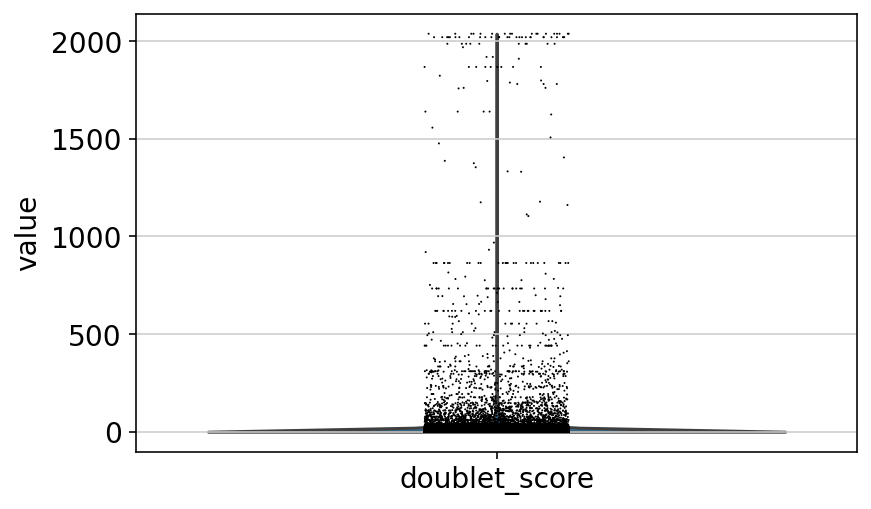

In [8]:
sc.pl.violin(adata, keys = "doublet_score", show=True, save = "doublet_score_violin2.png")

In [10]:
import doubletdetection
f3 = doubletdetection.plot.threshold(clf, save='./figures/threshold_test.pdf', show=True, p_step=6)

NameError: name 'clf' is not defined

In [11]:
adata.obs["doublet"]

AAACCTGGTGAGTGAC      0.0
AAATGCCAGAAGATTC      0.0
AAGACCTGTGAAAGAG      0.0
AATCCAGAGAGGTAGA      0.0
ACACCAAAGCGTGAGT      0.0
                     ... 
CTCGTCAGTAGAGTGC      0.0
ATCCGAAAGGTGTGGT-1    0.0
CCCAGTTAGGTACTCT      0.0
TGCGTGGAGTGGTCCC      0.0
CGTCACTCAAGCTGGA      0.0
Name: doublet, Length: 50000, dtype: float64

In [12]:
adata = adata[adata.obs["doublet"] == 0.0]
print('Number of cells after Doublet filter: {:d}'.format(adata.n_obs))

Number of cells after Doublet filter: 48926


/home/dan/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [13]:
import statistics
print("adata.shape")
print(adata.shape)
print("median counts per cell after filter:")
print(statistics.median(adata.obs['n_counts']))
print("median genes per cell after filter:")
print(statistics.median(adata.obs['n_genes']))

adata.shape
(48926, 19854)
median counts per cell after filter:
6943.5
median genes per cell after filter:
1973.0


/home/dan/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/dan/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


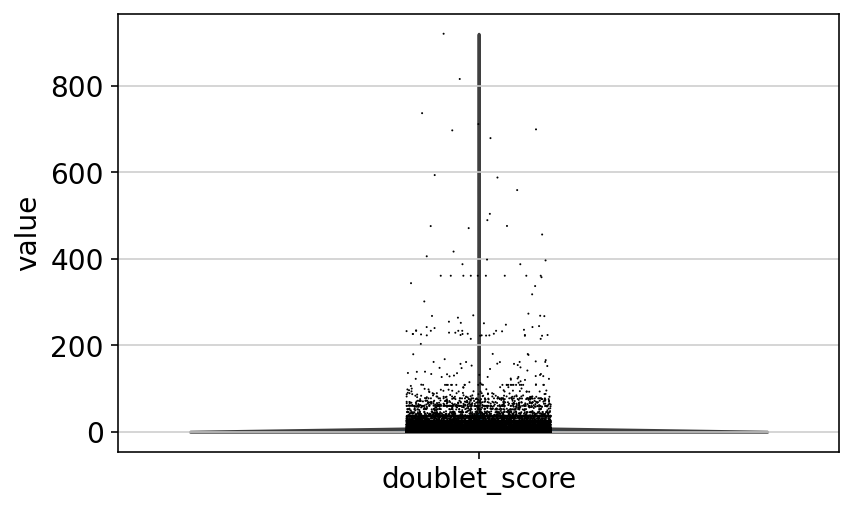

In [14]:
sc.pl.violin(adata, keys = "doublet_score", show=True, save = "doublet_score_violin3.png")

In [16]:
adata

View of AnnData object with n_obs × n_vars = 48926 × 19854
    obs: 'sample', 'age', 'batch', 'genotype_age', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'doublet', 'doublet_score'
    var: 'gene_id', 2, 'n_cells'

In [17]:
# the expression array contains 13,353 cells (obs) as rows and 27,998 genes (var) as columns
adata.X

ArrayView([[0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           ...,
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 1., 0., ..., 0., 0., 0.],
           [0., 1., 1., ..., 0., 3., 0.]], dtype=float32)

In [18]:
#sum(1) sums the columns; sum(0) sums the rows.
len(adata.X.sum(1))

48926

In [19]:
#Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()

In [20]:
# CPM normalization.
sc.pp.normalize_total(adata, target_sum=1e6)

/home/dan/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [22]:
sc.pp.log1p(adata, base=2.0)

In [23]:
import pickle

# obj0, obj1, obj2 are created here...

# Saving the objects:
with open('adata_normalized.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(adata, f)